In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
REGEX_COMMAS = re.compile(r'(,)')
REGEX_DOLLARS = re.compile(r'(\$)')

def parse_currency(x):
    if x == '' or x == '---':
        return np.nan
    else: 
        x = re.sub(REGEX_COMMAS, '', x)
        x = re.sub(REGEX_DOLLARS, '', x)
        return np.float64(x)
    
def parse_bool(x):
    if x == 'TRUE':
        return True
    elif x == 'FALSE':
        return False
    else:
        raise ValueError('Unable to parse to a bool: %s' % x)
        
def read_csv(fp):
    df = pd.read_csv(
        filepath_or_buffer=fp,
        index_col=False,
        dtype={
            'Year': np.int64,
            'Month': np.int64,
            'Day': np.int64,
            'Details': 'object',
            'Special transfers': 'object',
            'Project Codes': 'object',
            # 'AUD - Expenses': np.float64,
            # 'AUD - Income': np.float64,
            # 'AUD - Balance': np.float64,
            # 'Internal Transaction': np.bool,
            'Notes': 'object'
        },
        converters={
            'AUD - Expenses': parse_currency,
            'AUD - Income': parse_currency,
            'AUD - Balance': parse_currency,
            'IDR - Expenses': parse_currency,
            'IDR - Income': parse_currency,
            'IDR - Total': parse_currency,
            'IDR - Account Balance': parse_currency,
            'Via The SIES Account': parse_bool,
            'Internal Transaction': parse_bool,
        },
        skiprows=[1]
    )
    
    df['date'] = df[['Year', 'Month', 'Day']].T.apply(lambda x: pd.datetime(*x))
    print(df.shape)
    df = df[df['Internal Transaction']==False]
    print(df.shape)
    return df

In [3]:
def make_fy_filter(df, min_, max_):
    return (
        (df['date'] >= pd.datetime(year=min_[0], month=min_[1], day=1)) &
        (df['date'] <  pd.datetime(year=max_[0], month=max_[1], day=1))
    )

def make_financials_dataframe(bangalow_fp, bali_fp):
    Bangalow = read_csv(bangalow_fp)
    Bali = read_csv(bali_fp)
    
    currency_conversion = pd.Series(
        index=['2013/14', '2014/15', '2015/16', '2016/17', '2017/18'],
        data=[1/x for x in [10000, 10000, 10000, 10000, 10000]],
        name='idr_to_aud'
    )

    fys = [
        ('2013/14', (2013, 6), (2014, 7)),
        ('2014/15', (2014, 6), (2015, 7)),
        ('2015/16', (2015, 6), (2016, 7)),
        ('2016/17', (2016, 6), (2017, 7)),
        ('2017/18', (2017, 6), (2018, 7)),
    ]

    for a in ['IDR - Expenses', 'IDR - Income', 'IDR - Total', 'IDR - Account Balance']:
        b = re.sub(r'(IDR)', 'AUD', a)
        Bali[b] = None
        for fy, min_, max_ in fys:
            fy_filter = make_fy_filter(Bali, min_, max_)
            Bali.loc[fy_filter, b] = Bali.loc[fy_filter, a] * currency_conversion[fy]

    return pd.DataFrame(
        data={
            'date': pd.concat([Bangalow['date'], Bali['date']]),
            'income': pd.concat([Bangalow['AUD - Income'], Bali['AUD - Income']]),
            'expendature': pd.concat([Bangalow['AUD - Expenses'], Bali['AUD - Expenses']]),
            'project': pd.concat([Bangalow['Project Codes'], Bali['Project Codes']]),
        },
    )

In [1]:
from palettable.colorbrewer.diverging import Spectral_10 as clrs
from palettable.colorbrewer.sequential import Blues_9 as blues
from palettable.colorbrewer.sequential import Reds_9 as reds

LABELS = {    
    'income': [
        ('Balance', ('Balance',)),
        ('Grants', ('Donation-from-Taronga', 'Susukan-Baru-Project',)),
        ('Volunteer Program Income', (
            'General-Donation-via-Planet-Funder', 'SCU-Fundraising', 'SCU-Tour-Payments'
        )),
        ('Orangutan Conservation Campaign', ('Orangutan-Green-Projects',)),
        ('Elephant Conservation Campaign', ('Way-Kambas-National-Park-Elephant-Project',)),
        ('White Wind Duck Conservation Campaign', ('Way-Kambas-National-Park-WWD-Project',)),
        ('Eco-Tours Income', (
            'General-Tour', 'International-Park-Tours', 'Steppes-Travel-Tour',
            'Volunteer-Tour-Donation',
        )),
        ('Public Donations', (
            'Donation-for-Tigers', 'General-Donation', 'General-Donation-via-PayPal',
            'Recurring-Sponsorships',
        )),
        ('Habitat Regeneration Campaign', ('Way-Kambas-National-Park-Reforestation-Project',)),
        ('Other Projects', ('Way-Kambas-National-Park-General')),
        ('Orangutan Conservation Projects', ('Yayasan-Orangutan-Sumatra-Lestari',)),
        ('ERRORS', ('Administration-Expense', 'Administrative-Expense', 'Bank-Transfer-Expense'
                   'Tour-Expense-Cash-Withdrawal', 'Transfer-to-the-Bali-Account'))
    ],
    'expendature':[
        ('Fees', ('Administration-Expense', 'Administrative-Expense', 'Bank-Transfer-Expense',)),
        ('Volunteer Program Costs', ('ALeRT-Tour-Donation', 'SCU-Tour-Payments')),
        ('Orangutan Conservation Projects', (
            'Friends-of-the-National-Park-Foundation', 'Gunung-Palung-National-Park',
            'Orangutan-Green-Projects', 'Yayasan-Orangutan-Sumatra-Lestari',
        )),
        ('Habitat Regeneration Projects', (
            'Susukan-Baru-Project', 'Way-Kambas-National-Park-Firefighting-Project',
            'Way-Kambas-National-Park-Reforestation-Project',
        )),
        ('Eco-Tours Expenses', ('Tour-Expense-Cash-Withdrawal', 'International-Park-Tours')),
        ('Other Projects', ('Way-Kambas-National-Park-General', 'Recurring-Sponsorships')),
        ('Elephant Conservation Projects', ('Way-Kambas-National-Park-Elephant-Project',)),
        ('White Wind Duck Conservation Projects', ('Way-Kambas-National-Park-WWD-Project',)),
        ('ERRORS', ('Transfer-Error', 'General-Donation', 'General-Donation-via-PayPal', 'SCU-Fundraising',
                   'Volunteer-Tour-Donation', 'Transfer-to-the-Bali-Account'))
    ]
}

def reverse_labels(labels):
    for i in labels:
    print(i)
    for j, ks in labels[i]:
        for k in ks:
            print("'{}': '{}',".format(k, j))

def group_financials(df, start_year, field):
    print('Grouping:', field)
    fy_year = (start_year, 6), (start_year + 1, 7)
    print(fy_year)
    fy_filter = make_fy_filter(df, fy_year[0], fy_year[1])
    grouped = df[fy_filter].groupby('project').sum()[field]
    
    if field == 'expendature':
        grouped *= -1
    grouped = grouped[grouped.notnull()]
    labeled = pd.Series(
        index=[a for a, _ in LABELS[field]],
        data=[sum([maybe(grouped, a) for a in names]) for _, names in LABELS[field]]
    )
    labeled = labeled[labeled.values >= 0.000001]
    totals_check(grouped, labeled)
    return labeled

def totals_check(grouped, labeled):
    if abs(grouped.values.sum() - labeled.values.sum()) > 0.000001:
        print(grouped.values.sum() - labeled.values.sum())
        raise ValueError('Totals check failed, are some project codes not being grouped?')
        
def maybe(grouped, a):
    if a in grouped.index:
        return grouped[a]
    else:
        return 0

def pie_chart(df, start_year, field):
    groups = group_financials(df, start_year, field)
    labels = [('%.1f%% - ' % (groups[a]/groups.sum()*100) + re.sub(r'-', ' ', a)) for a in groups.index]
    
    if field == 'expendature':
        cmap = reds
    elif field == 'income':
        cmap = blues
    else:
        raise ValueError(field)
    
    fig = plt.figure(figsize=(10, 6))
    # plt.title(
    #     '%s by source for FY %i-%i' %
    #     (field.capitalize(), start_year, start_year + 1 - 2000),
    #     fontsize=16
    # )
    my_circle=plt.Circle((0,0), 0.5, color='white')
    
    to_recolour = [] # ['Fees']
    colours = ['#2f4f4f' if a in to_recolour else cmap.hex_colors[i] for i, a in enumerate(groups.index)]
    # colours = cmap.hex_colors
    
    _, texts = plt.pie(
        groups.values,
        labels=labels,
        center=(0, 0),
        colors=colours,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    # plt.legend(
    #     patches, labels,
    #     loc='center right',
    #     # bbox_to_anchor=(-0.1, 1.),
    #    # fontsize=8,
    # )
    [t.set_fontsize(12) for t in texts]
    
    if field == 'expendature':
        plt.arrow(1.08, 0.015, -0.04, 0.0, head_width=0.025, head_length=0.02)
        pass
    elif field == 'income':
        cmap = blues
    else:
        raise ValueError(field)
    
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    # plt.tight_layout()
    plt.savefig('/Users/coelrichs/Desktop/%s-pie-chart.png' % field, format='png', dpi=400)  # , bbox_inches='tight')
    plt.show()
    fig.clf()
    plt.close(fig)
    
df = make_financials_dataframe(
    '../../../Documents/SIES/data/SIES - Bangalow - Sheet1 - 2018-10-14.csv',
    '../../../Documents/SIES/data/SIES - Indonesia - Sheet1 - 2018-10-14.csv'
)
print('Making pie charts.')
pie_chart(df, 2017, 'income')
pie_chart(df, 2017, 'expendature')

IndentationError: expected an indented block (<ipython-input-1-d5c98e4a3893>, line 51)

In [5]:
def financial_table(df, start_year, field):
    grouped = group_financials(df, start_year, field)
    print(field.capitalize())
    for a in grouped.index:
        print('%s, %.2f' % (a, grouped[a]))
    
financial_table(df, 2017, 'income')
financial_table(df, 2017, 'expendature')

Grouping: income
((2017, 6), (2018, 7))
Income
Volunteer Program Income, 64199.00
Elephant Conservation Campaign, 20000.00
White Wind Duck Conservation Campaign, 21612.00
Eco-Tours Income, 6200.00
Public Donations, 21991.12
Habitat Regeneration Campaign, 3000.00
Grouping: expendature
((2017, 6), (2018, 7))
Expendature
Fees, 640.00
Volunteer Program Costs, 40741.87
Habitat Regeneration Projects, 51307.53
Eco-Tours Expenses, 1500.00
Elephant Conservation Projects, 52000.00
White Wind Duck Conservation Projects, 20000.00


(225, 12)
(197, 12)
(146, 14)
(115, 14)


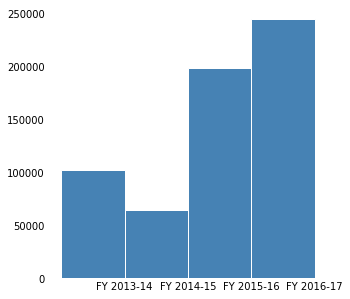

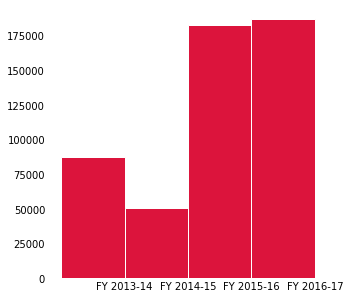

In [6]:
# rc('font', weight='bold')

def fy_comparison_chart(df, start_year, field, colour):
    values = []
    labels = []
    for i in (0, 1, 2, 3):
        fy_filter = make_fy_filter(df, (start_year + i, 6), (start_year + i + 1, 7))
        value = df[fy_filter][field].sum()
        if field == 'expendature':
            value *= -1
        values += [value]
        labels += ['FY %i-%i' % (start_year + i, start_year + i + 1 - 2000)]
 
    fig = plt.figure(figsize=(5, 5))
    bar_width = 1
    plt.bar([0, 1, 2, 3], values, color=colour, edgecolor='white', width=bar_width)

    # Custom X axis
    plt.xticks([0.5, 1.5, 2.5, 3.5], labels)
    # plt.title('%s by FY (AUD)' % field.capitalize())
    # plt.ylabel('AUD ($)')
    ax = fig.axes[0]
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    plt.savefig('/Users/coelrichs/Desktop/%s-comparison-chart.png' % field, format='png', dpi=200, bbox_inches='tight')
    plt.show()
    fig.clf()
    plt.close(fig)

df = make_financials_dataframe(
    '../../../Documents/SIES/data/SIES - Bangalow - Sheet1 - 2018-10-14.csv',
    '../../../Documents/SIES/data/SIES - Indonesia - Sheet1 - 2018-10-14.csv'
)

# print(df[make_fy_filter(df, (2015, 6), (2016, 7))].sum())
# print(df[make_fy_filter(df, (2016, 6), (2017, 7))].sum())

# print(df[make_fy_filter(df, (2015, 6), (2016, 7))])
# print(df[make_fy_filter(df, (2016, 6), (2017, 7))].sum())

fy_comparison_chart(df, 2013, 'income', '#4682B4')
fy_comparison_chart(df, 2013, 'expendature', '#DC143C')